# Elliptic Data Set

[1] Elliptic, www.elliptic.co.

[2] M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.

### Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx

### Load Data

In [2]:
df_classes = pd.read_csv('../data/raw/elliptic_txs_classes.csv')
df_edgelist = pd.read_csv('../data/raw/elliptic_txs_edgelist.csv')
df_features = pd.read_csv('../data/raw/elliptic_txs_features.csv', header=None)

display(df_classes, df_edgelist, df_features)

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown
...,...,...
203764,173077460,unknown
203765,158577750,unknown
203766,158375402,1
203767,158654197,unknown


,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


### Preprocessing

In [3]:
# Map class labels: '2' → 0 (licit), '1' → 1 (illicit), 'unknown' → 2
if df_classes['class'].dtype == object:
    df_classes['class'] = df_classes['class'].map({'2':0, '1':1, 'unknown':2})

# Rename columns
df_features.columns = ['txId', 'timeStep'] + [f'localF{i}' for i in range(94)] + [f'aggregatedF{i}' for i in range(71)]

# Map txIds to indices
txId_mapping = {txId: idx for idx, txId in enumerate(df_features['txId'].unique())}
mapping_df = pd.DataFrame(list(txId_mapping.items()), columns=['txId', 'nodeId'])

df_features['txId'] = df_features['txId'].map(txId_mapping)
df_classes['txId'] = df_classes['txId'].map(txId_mapping)
df_edgelist = df_edgelist.map(txId_mapping.get)

# Merge classes and features
df_node = pd.merge(df_classes, df_features, on='txId')

# df_edgelist.to_csv('../data/processed/edge_data.csv', index=False)
# df_node.to_csv('../data/processed/node_data.csv', index=False)
# mapping_df.to_csv('../data/processed/txId_nodeId_mapping.csv', index=False)

display(df_edgelist, df_node)

,txId1,txId2
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9
...,...,...
234350,203602,201430
234351,203603,203099
234352,201921,202042
234353,201480,201368


,txId,class,timeStep,localF0,localF1,localF2,localF3,localF4,localF5,localF6,...,aggregatedF61,aggregatedF62,aggregatedF63,aggregatedF64,aggregatedF65,aggregatedF66,aggregatedF67,aggregatedF68,aggregatedF69,aggregatedF70
0,0,2,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,1,2,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,2,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,3,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,4,2,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,203764,2,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,203765,2,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,203766,1,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,203767,2,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


### Exploratory Data Analysis (EDA)

- Class Distribution

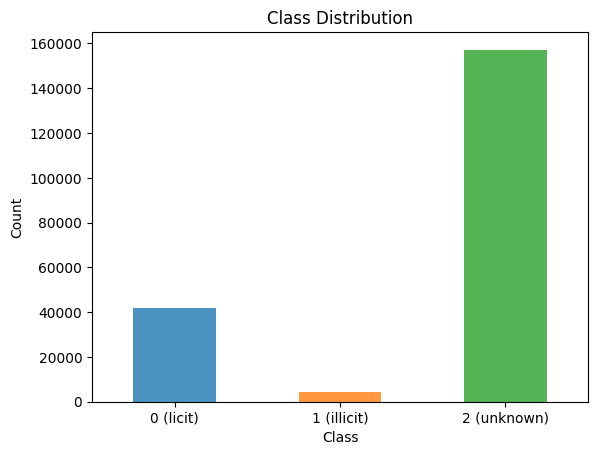

In [4]:
class_counts = df_node.value_counts('class').sort_index()
class_counts.plot(
    kind='bar', 
    title='Class Distribution', 
    xlabel='Class', 
    ylabel='Count', 
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'], 
    alpha=0.8)
plt.xticks(ticks=range(3), labels=['0 (licit)', '1 (illicit)', '2 (unknown)'], rotation=0)
plt.show()

- Class Distribution per Time Step

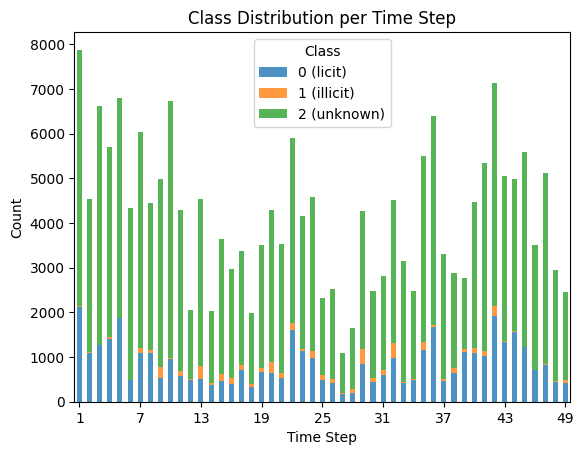

In [5]:
class_counts_by_time = df_node.value_counts(['timeStep', 'class']).unstack()
ax = class_counts_by_time.plot(
    kind='bar', 
    stacked=True, 
    title='Class Distribution per Time Step', 
    xlabel='Time Step', 
    ylabel='Count', 
    alpha=0.8)

ax.legend(['0 (licit)', '1 (illicit)', '2 (unknown)'], title='Class')
plt.xticks(ticks=range(0, len(class_counts_by_time), 6), rotation=0)
plt.show()

- Transaction Graph

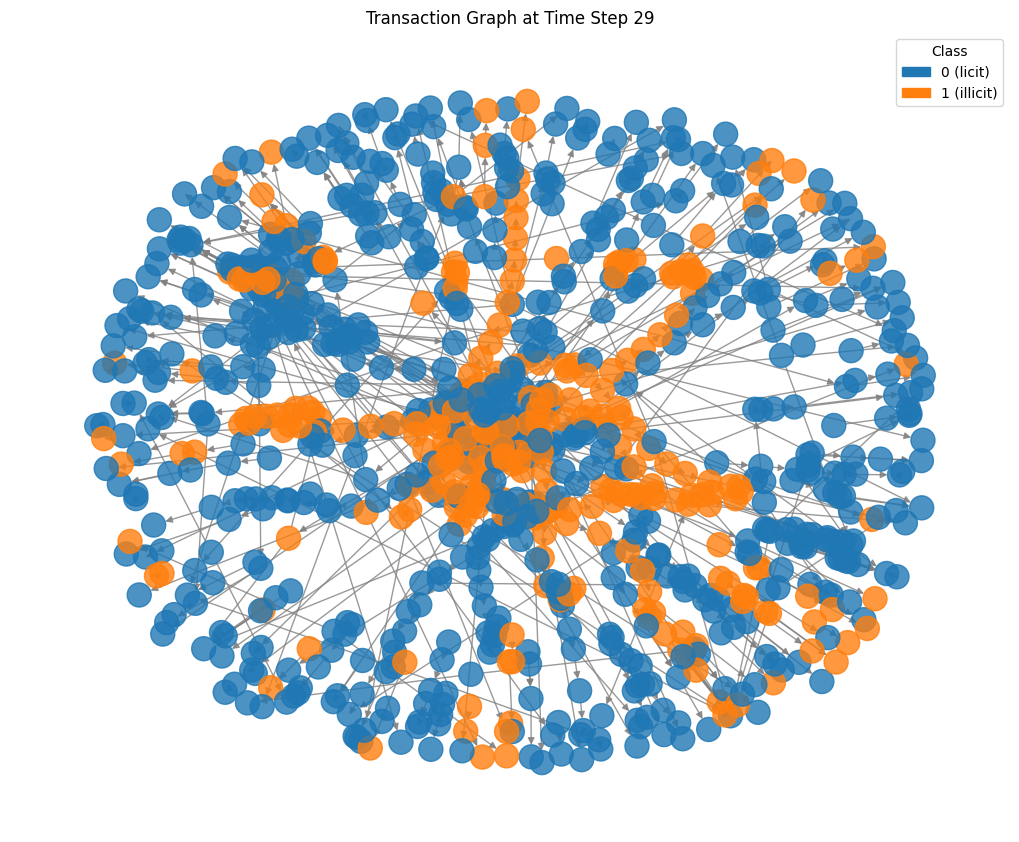

In [6]:
# Filter for timeStep 29 and knwon classes
txIds_t29_known = df_node[(df_node['timeStep'] == 29) & (df_node['class'] != 2)]['txId']
edges_t29_known = df_edgelist[df_edgelist['txId1'].isin(txIds_t29_known) & df_edgelist['txId2'].isin(txIds_t29_known)]

# Create graph
G = nx.DiGraph()
G.add_edges_from(zip(edges_t29_known['txId1'], edges_t29_known['txId2']))

# Add class labels to nodes
tx_class_map = df_node.set_index('txId')['class'].to_dict()
nx.set_node_attributes(G, tx_class_map, name='class')

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

node_colors = [f"C{G.nodes[n].get('class', 0)}" for n in G.nodes]

nx.draw(
    G, pos,
    with_labels=False,
    node_size=300,
    node_color=node_colors,
    edge_color='gray',
    alpha=0.8
)

legend = [
    mpatches.Patch(color='C0', label='0 (licit)'),
    mpatches.Patch(color='C1', label='1 (illicit)'),
]

plt.title("Transaction Graph at Time Step 29")
plt.legend(handles=legend, title='Class')
plt.show()